# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## 0. Importing the neccesary requirements

In [1]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
from IPython.display import HTML

%matplotlib qt
%matplotlib inline

## 1. Camera Calibration

##### Compute the camera calibration matrix given a set of chessboard images.(Taken from Udacity Quiz)

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
calibration_output_images  = []

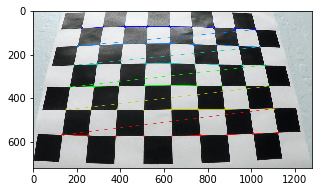

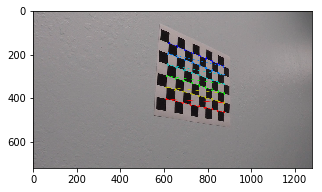

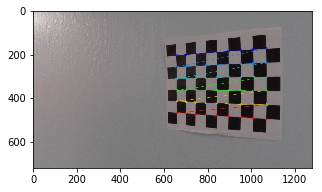

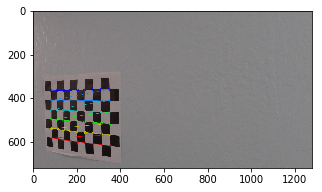

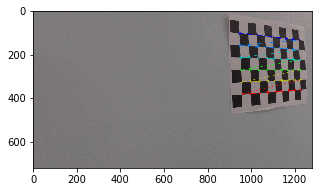

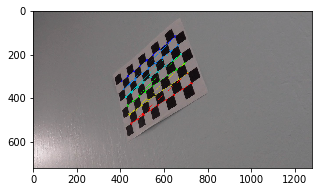

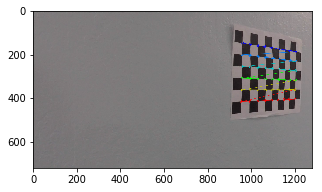

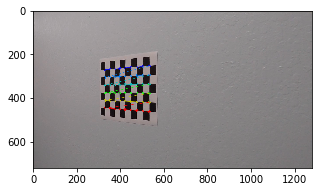

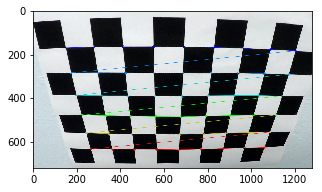

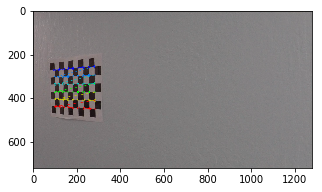

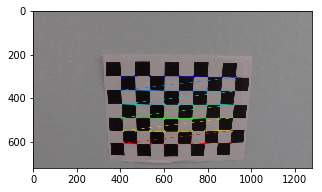

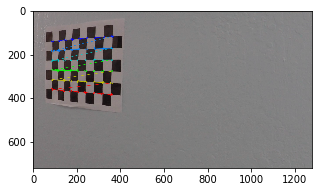

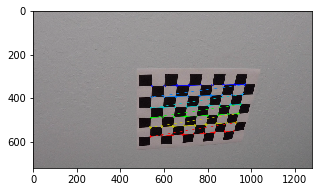

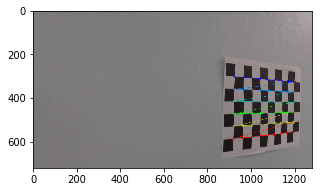

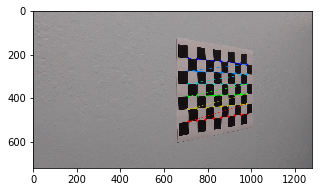

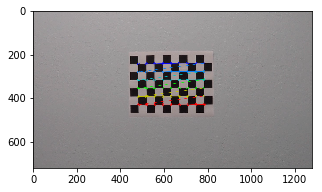

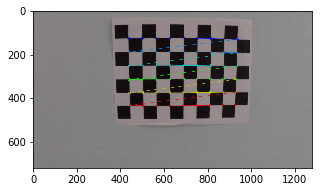

In [3]:
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners; ny = 9 and nx = 6 (# of corners)
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None) 
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners; # ny = 9 and nx = 6 (# of corners)
        plt.figure(figsize=(5,5))
        img = cv2.drawChessboardCorners(img,(9,6),corners,ret) 
        plt.imshow(img)

## 2. Distortion Correction

##### Compute the distortion coefficients for the given a set of chessboard images
##### Before undistorting images

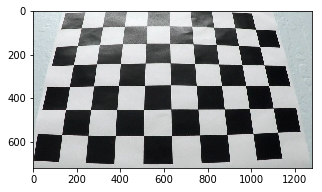

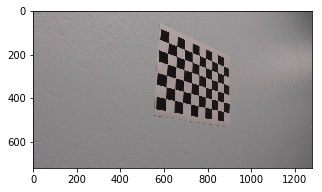

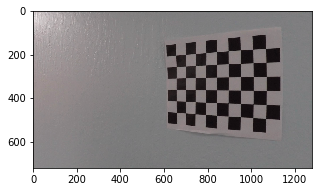

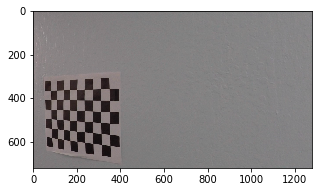

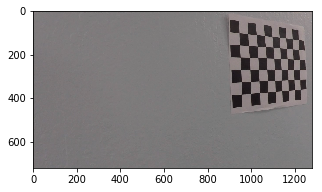

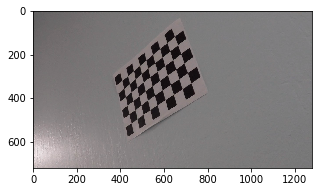

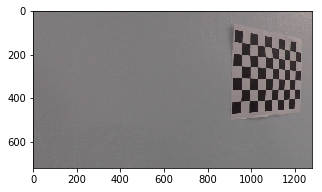

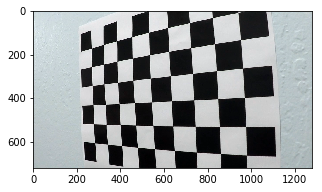

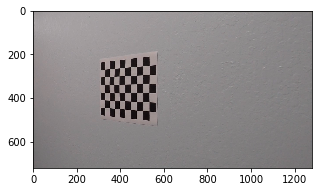

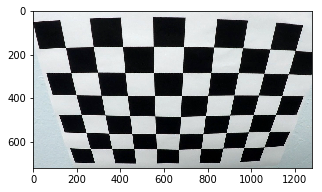

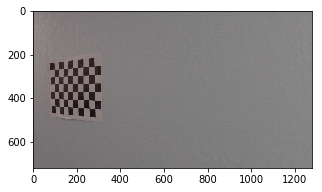

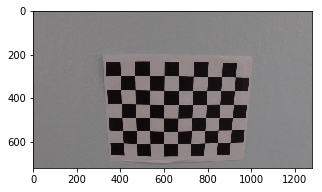

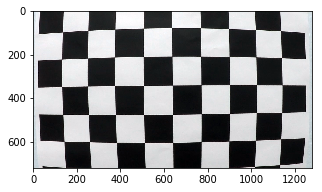

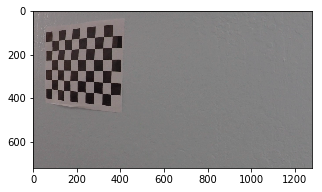

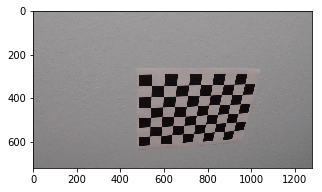

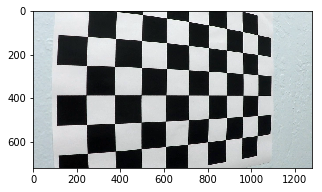

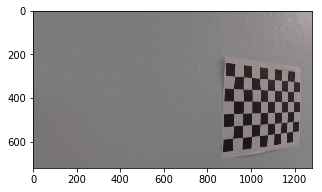

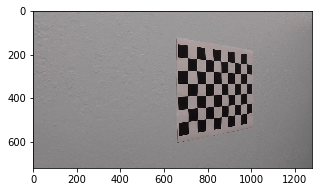

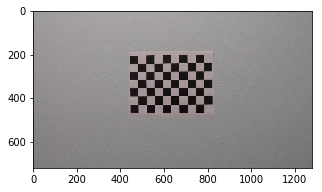

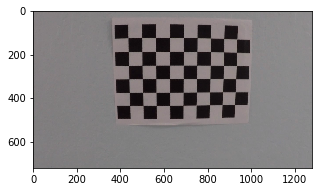

In [4]:
imgaes = cv2.imread('camera_cal/calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    plt.figure(figsize=(5,5))
    plt.imshow(img)

##### After undistorting images

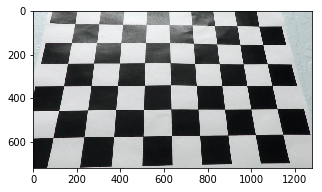

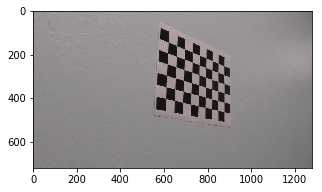

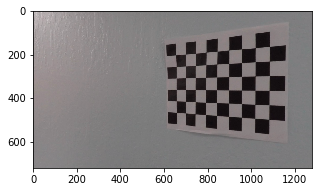

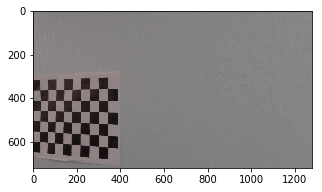

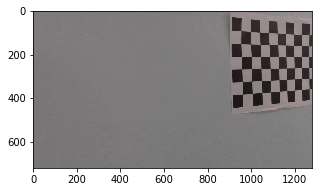

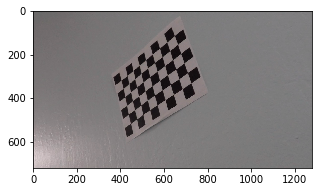

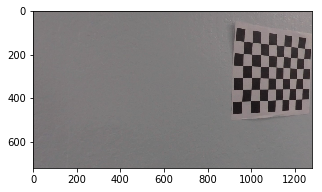

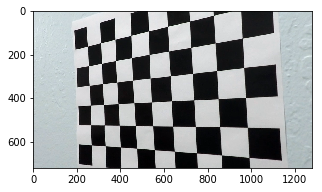

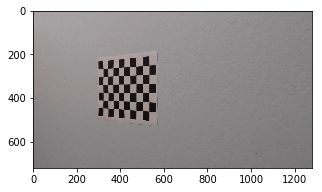

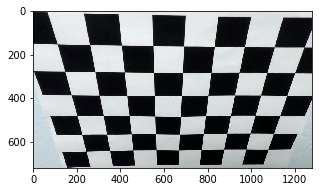

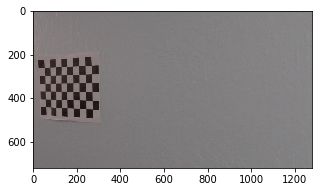

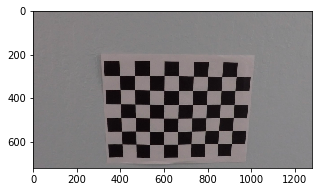

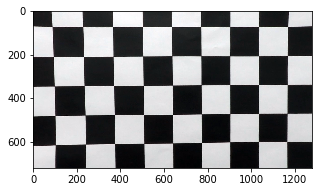

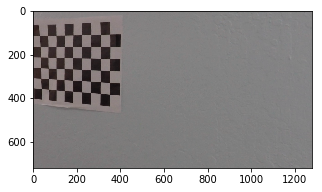

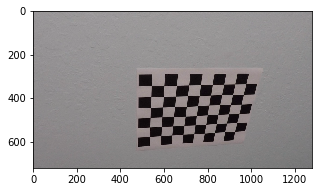

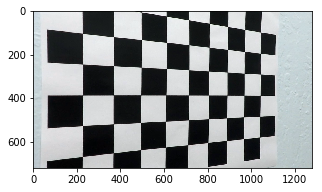

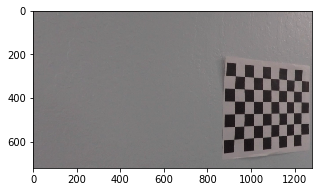

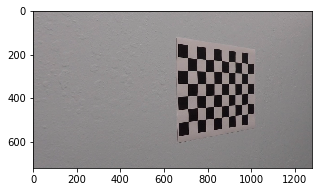

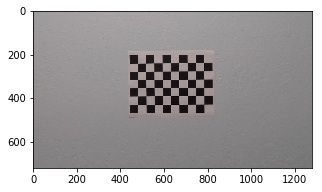

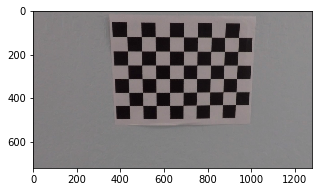

In [5]:
# Takes an image, object points, and image points performs the camera calibration, image distortion correction and 
# returns the undistorted image.
imgaes = cv2.imread('camera_cal/calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    plt.figure(figsize=(5,5))
    plt.imshow(undistorted)

## 2.1] Distortion correction for roads

##### Use color transforms, gradients, etc., to create a thresholded binary image.
##### Before undistorting the images

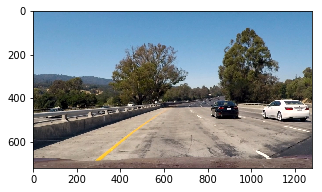

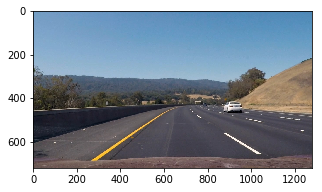

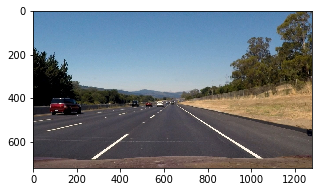

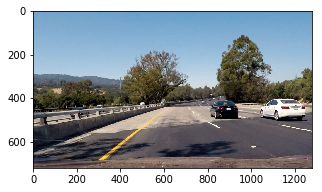

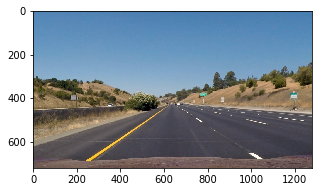

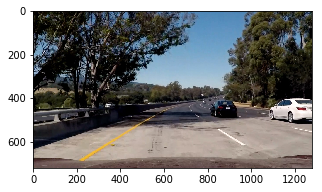

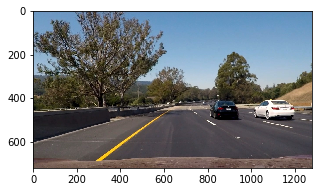

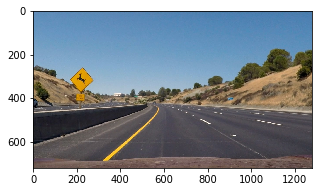

In [6]:
test_images_calibration = glob.glob('./test_images/*.jpg')
for fname in test_images_calibration:
    test_images = mpimg.imread(fname)
    plt.figure(figsize=(5,5))
    plt.imshow(test_images)

##### After undistorting the images

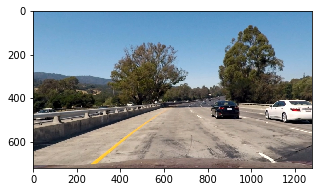

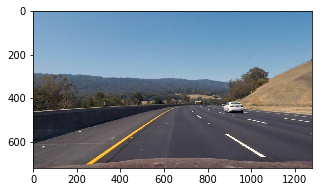

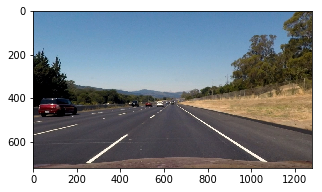

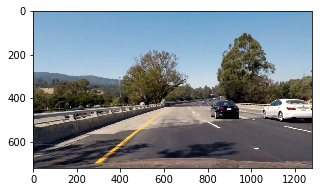

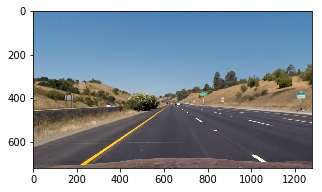

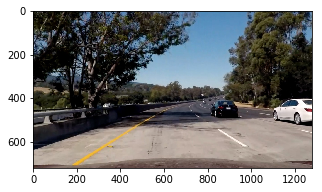

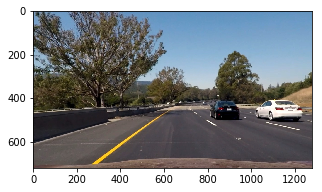

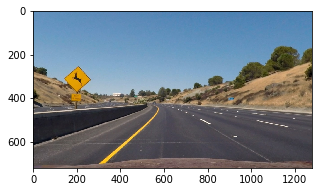

In [7]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)
test_images = glob.glob('./test_images/*.jpg')
# Creating lists to append all the images into
undistorted_images=[]
original_images=[]
output_test_images=[]

for i, fname in enumerate(test_images): 
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    output_test_images.append(img)
    original_images.append(img)

    # Undistoring all of the test images
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Saving to the output folder
    undistorted_images.append(undist) 
    output_test_images.append(undist)
    plt.figure(figsize = (5,5))
    plt.imshow(undist)


## 3. Perspective Transform

##### Apply a perspective transform to rectify binary image ("birds-eye view"). (Taken from Udacity Quiz)

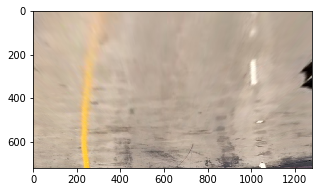

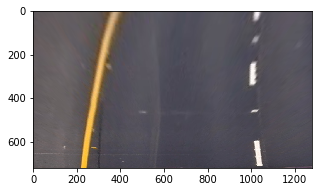

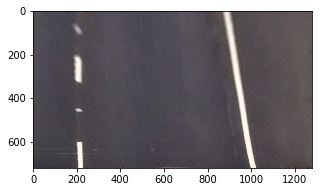

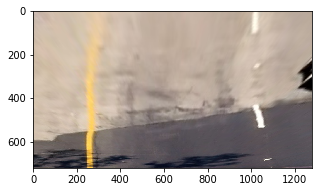

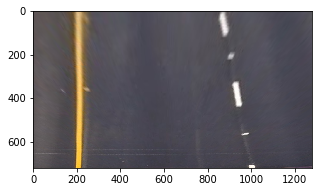

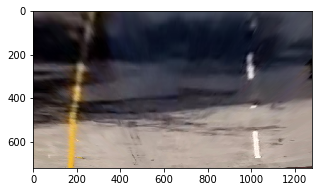

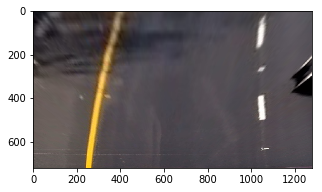

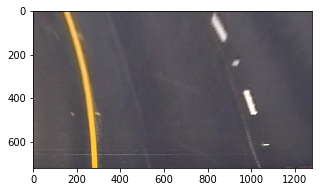

In [8]:
output_test_images = []
warped_images = []
Minvs = []

test_images_perspective_transform = glob.glob('./test_images/*.jpg')

for fname in test_images_perspective_transform: 
    test_images = mpimg.imread(fname)
    
    # Getting the image size to determine what the corners will be
    image_sizes = (test_images.shape[1], test_images.shape[0])
    
    # Getting the width and height of an image
    x = image_sizes[0]
    y = image_sizes[1]
      
    # Grabbing the outer four corners - Top right, top left. bottom right, and bottom left
    source_points = np.float32([[580,460],[740,460],[1100,670],[270,670]])
    
    # Getting an offset so that we can get a good aspect ratio
    offset = 0
    
    # Choosing some destination points that seem correct/close
    destination_points = np.float32([[200, offset], [x - 200, offset], [x - 200, y], [200, y]])

    # Using the source corners and the destionation points I am doing a perspective transform
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    image_warp = cv2.warpPerspective(test_images, M, image_sizes, flags=cv2.INTER_LINEAR)
    
    # Adding images to files
    output_test_images.append(undist)    
    Minvs.append(Minv)
    warped_images.append(image_warp)
    
    # Plots warped
    plt.figure(figsize = (5,5))
    plt.imshow(image_warp)
    

## 4. Gradients

##### Applying Sobel Operator (taken from udacity quiz)

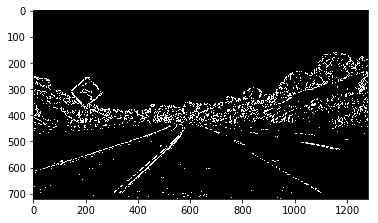

In [9]:
warped_image = warped_images[5]
hls_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2HLS)
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    thresh_min = 20
    thresh_max = 100
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

test_images_perspective_transform = glob.glob('./test_images/*.jpg')
for fname in test_images_perspective_transform:
    test_images = mpimg.imread(fname)
    grad_binary = abs_sobel_thresh(undist, orient='x', sobel_kernel = 3, thresh = (20,255))
    plt.imshow(grad_binary, cmap='gray')

##### Applying the magnitude of the gradient (taken from udacity quiz)

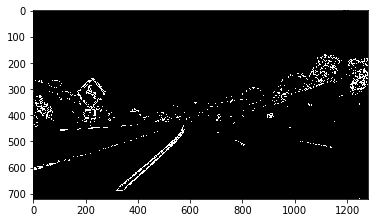

In [10]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

test_images_perspective_transform = glob.glob('./test_images/*.jpg')
for fname in test_images_perspective_transform:
    test_images = mpimg.imread(fname)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    plt.imshow(mag_binary, cmap = 'gray')

##### Applying the direction of the gadient (taken from quiz)

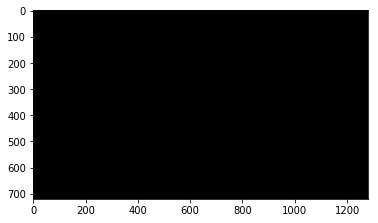

In [11]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])]
    # Return the binary image
    return binary_output

test_images_perspective_transform = glob.glob('./test_images/*.jpg')
for fname in test_images_perspective_transform:
    test_images = mpimg.imread(fname)
    dir_binary = dir_threshold(img, sobel_kernel=1, thresh=(0.7, 1.3))
    plt.imshow(dir_binary, cmap = 'gray')

##### Combining Threshold (taken from udacity quiz)

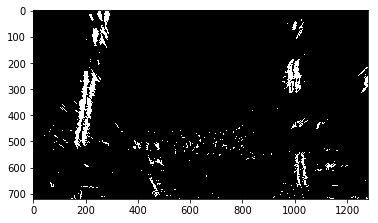

In [12]:
def combined_thresh(img, sobel_kernel=3, abs_thresh=(15,255), _mag_thresh=(15,255), dir_thresh=(0, np.pi/2)):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=abs_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=sobel_kernel, thresh=(0, 255))
    mag_binary = mag_thresh(img, sobel_kernel=sobel_kernel, mag_thresh=_mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, thresh=dir_thresh)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
combined = combined_thresh(warped_images[5], sobel_kernel=3, abs_thresh=(20,255), _mag_thresh=(20,255), dir_thresh=(0, np.pi/2))
plt.imshow(combined, cmap='gray')

## 4.1 HLS Color Spaces

##### "Here we'll explore this a bit further and look at a couple examples to see why a color space like HLS can be more robust" (Taken from Udacity Quiz)

In [13]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [14]:
test_images_HLS= glob.glob('./test_images/*.jpg')
for fname in test_images_HLS:
    test_images = mpimg.imread(fname)
    hls_binary = hls_select(undist, thresh=(90, 255))
    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Defining the treshold to use
    thresh1 = (90, 255)
        
    # H Channel
    binary_H = np.zeros_like(H)
    binary_H[(H > thresh1[0]) & (H <= thresh1[1])] = 1
    
    # L Channel
    binary_L = np.zeros_like(L)
    binary_L[(L > thresh1[0]) & (L <= thresh1[1])] = 1
    
    # S Channel
    binary_S = np.zeros_like(H)
    binary_S[(S > thresh1[0]) & (S <= thresh1[1])] = 1

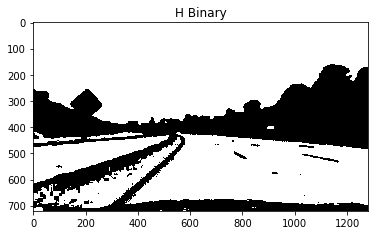

In [15]:
#Plot the H channel
#plt.figure(figsize=(5,5))
plt.title("H Binary")
plt.imshow(binary_H, cmap = 'gray') 

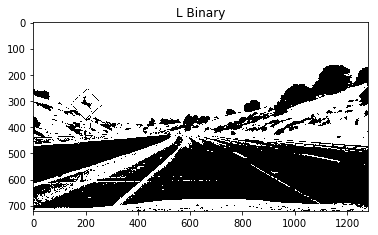

In [16]:
#Plot the L channel
#plt.figure(figsize=(5,5))
plt.title("L Binary")
plt.imshow(binary_L, cmap = 'gray') 

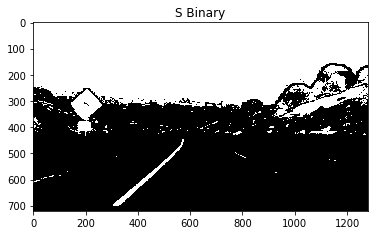

In [17]:
# Plot the S channel
#plt.figure(figsize=(5,5))
plt.title("S Binary")
plt.imshow(binary_S, cmap = 'gray')

## 5. Detect lane pixels and fit to find the lane boundary

##### Creating a histogram for all warped images (Taken from Udacity Quiz)

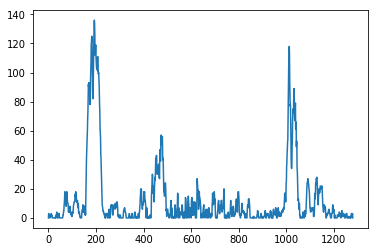

In [18]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram
# Create histogram of image binary activations
histogram = hist(combined)
# Visualize the resulting histogram
plt.plot(histogram)

##### Sliding Window Plotting (Taken form udacity quiz)

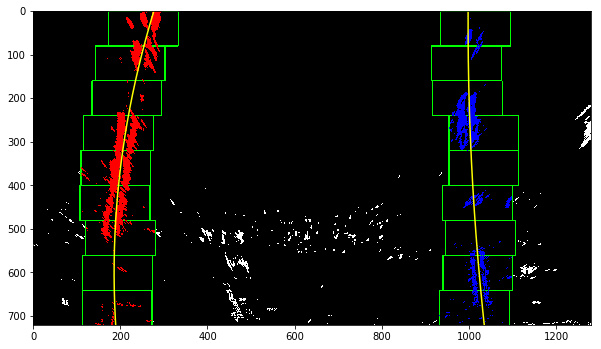

In [19]:
def sliding(img):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, out_img

def visualize(img, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    plt.figure(figsize = (10,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = sliding(combined)
visualize(combined, out_img, left_fit, right_fit, left_lane_inds, right_lane_inds)

##### Search From Prior (Taken From Quiz)

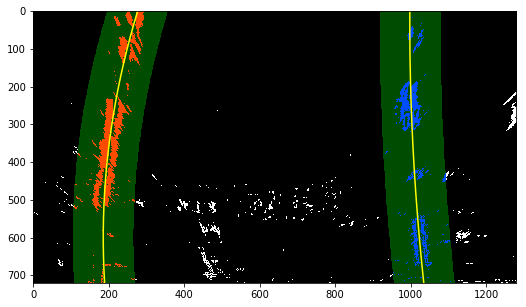

In [20]:
def poly(binary_warped, left_fit, right_fit):
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 80
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return out_img, left_fit, right_fit, left_lane_inds, right_lane_inds
    
def visualize_poly(binary_warped, out_img, left_fitx, right_fitx, left_lane_inds, right_lane_inds):
    margin = 80    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.figure(figsize = (10,5))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
out_img, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = poly(combined, left_fit, right_fit)
visualize_poly(combined, out_img, left_fit2, right_fit2, left_lane_inds2, right_lane_inds2)

## 6. Determine the radius of curvature of the lane and vehicle position with respect to center.

##### Partially Taken From udacity quiz

In [21]:
def curverad_calculation(binary_warped, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    nonzero = binary_warped.nonzero()
    # Fit new polynomials to x,y in world space
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*np.polyfit(np.array(nonzero[0])[left_lane_inds]*ym_per_pix, np.array(nonzero[1])[left_lane_inds]*xm_per_pix, 2)[0]*np.max(np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]))*ym_per_pix + np.polyfit(np.array(nonzero[0])[left_lane_inds]*ym_per_pix, np.array(nonzero[1])[left_lane_inds]*xm_per_pix, 2)[1])**2)**1.5) / np.absolute(2*np.polyfit(np.array(nonzero[0])[left_lane_inds]*ym_per_pix, np.array(nonzero[1])[left_lane_inds]*xm_per_pix, 2)[0])
    right_curverad = ((1 + (2*np.polyfit(np.array(nonzero[0])[right_lane_inds]*ym_per_pix, np.array(nonzero[1])[right_lane_inds]*xm_per_pix, 2)[0]*np.max(np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]))*ym_per_pix + np.polyfit(np.array(nonzero[0])[right_lane_inds]*ym_per_pix, np.array(nonzero[1])[right_lane_inds]*xm_per_pix, 2)[1])**2)**1.5) / np.absolute(2*np.polyfit(np.array(nonzero[0])[right_lane_inds]*ym_per_pix, np.array(nonzero[1])[right_lane_inds]*xm_per_pix, 2)[0])
    return left_curverad, right_curverad
def car_position_calculation(binary_warped, left_fit, right_fit):
    # Getting the positio of the car from the center
    center_position = (binary_warped.shape[1]/2 - (right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2] + left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]) /2) * 3.7/700
    return center_position

left_curverad, right_curverad = curverad_calculation(combined, left_lane_inds2, right_lane_inds2)
center_position_car = car_position_calculation(combined, left_fit2, right_fit2)
print('The left curve is', left_curverad, 'm')
print('The right curve is', right_curverad, 'm')
print('The position of the car from, the center is ', center_position_car, 'm')

The left curve is 720.913680544 m
The right curve is 1151.75454388 m
The position of the car from, the center is  0.150535752764 m


## 7. Warp the detected lane boundaries back onto the original image

##### Taken from udacity lesson "tips and tricks for project"

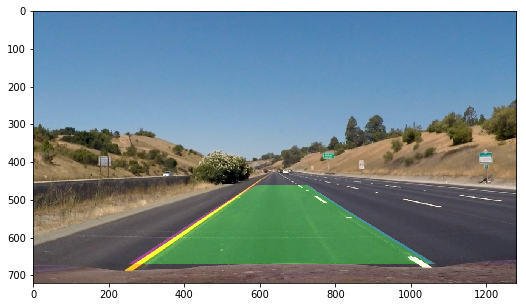

In [22]:
def draw_car_lane_and_data(original_img, binary_img, left_fit, right_fit, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fit[0]*np.linspace(0, combined.shape[0]-1, combined.shape[0])**2 + left_fit[1]*np.linspace(0, combined.shape[0]-1, combined.shape[0]) + left_fit[2], np.linspace(0, combined.shape[0]-1, combined.shape[0])]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fit[0]*np.linspace(0, combined.shape[0]-1, combined.shape[0])**2 + right_fit[1]*np.linspace(0, combined.shape[0]-1, combined.shape[0]) + right_fit[2], np.linspace(0, combined.shape[0]-1, combined.shape[0])])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_images[4].shape[1], original_images[4].shape[0])) 
       
    # Combine the result with the original image
    result = cv2.addWeighted(original_images[4], 1, newwarp, 0.3, 0)
    
    #plt.imshow(result)
    return result

def put_text_on_data(img, curv_rad, car_pos):
    cv2.putText(img, 'Radius: ' + '{:02.2f}'.format( ((left_curverad + right_curverad)/2) /1000) + 'Km', (30,70), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255,0), 2, cv2.LINE_AA)
    cv2.putText(img, 'Distance from Center: ' + '{:02.3f}'.format(center_position_car) + 'm', (30,120), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255,0), 2, cv2.LINE_AA)
    return img

drawn_image = draw_car_lane_and_data(original_images[3], combined, left_fit, right_fit, Minvs[3])
plt.figure(figsize = (10,5))
plt.imshow(drawn_image)

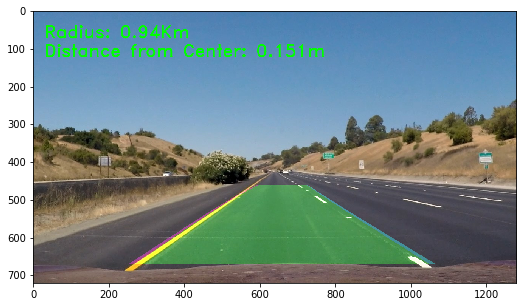

In [23]:
final_drawn_image_with_data = put_text_on_data(drawn_image, (left_curverad + right_curverad)/2, center_position_car)
plt.figure(figsize = (10,5))
plt.imshow(final_drawn_image_with_data)

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [28]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 
        # pixels
        #self.px_count = None

    def add_best_fit(self, lane_fit, lane_inds): 
        ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
        #left_fit = np.polyfit(lefty, leftx, 2)
        #right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        #ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
        #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        if lane_fit is None:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            if self.best_fit is not None:
                self.diffs = abs(lane_fit - self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(lane_inds)
                self.current_fit.append(lane_fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = lane_fit


###### Defining Pipeline 

In [29]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
    
def warp(img):
    # Getting the image size to determine what the corners will be
    image_sizes = (img.shape[1], img.shape[0])
    
    # Getting the width and height of an image
    x = image_sizes[0]
    y = image_sizes[1]
      
    # Grabbing the outer four corners - Top right, top left. bottom right, and bottom left
    source_points = np.float32([[580,460],[740,460],[1100,670],[270,670]])
    
    # Getting an offset so that we can get a good aspect ratio
    offset = 0
    
    # Choosing some destination points that seem correct/close
    destination_points = np.float32([[200, offset], [x - 200, offset], [x - 200, y], [200, y]])

    # Using the source corners and the destionation points I am doing a perspective transform
    M = cv2.getPerspectiveTransform(source_points, destination_points)
    Minv = cv2.getPerspectiveTransform(destination_points, source_points)
    image_warp = cv2.warpPerspective(img, M, image_sizes, flags=cv2.INTER_LINEAR)
    
    return image_warp, M, Minv

#def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    #ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #return left_fitx, right_fitx, ploty

In [30]:
def video(img): 
    # Original image
    original = np.copy(img)
    
    # Undistorting
    undistorted = undistort(original)
    
    # Warping
    warped, M, Minv = warp(undistorted)
    
    # Combining
    binary_img = combined_thresh(warped)
    
    if not left_line.detected or not right_line.detected:
        # Sliding window fit
        left_fit, right_fit, left_lane_inds, right_lane_inds, out_img = sliding(binary_img)
    else:
        # Search from prior
        out_img, left_fit, right_fit, left_lane_inds, right_lane_inds = poly(binary_img, left_line.best_fit, right_line.best_fit)

    left_line.add_best_fit(left_fit, left_lane_inds)
    right_line.add_best_fit(right_fit, right_lane_inds)
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        print(left_line.best_fit)
        print(right_line.best_fit)
        # Drawing lanes
        lane_img = draw_car_lane_and_data(original, binary_img, left_line.best_fit, right_line.best_fit, Minv)

        # Calculating curvature
        left_curverad, right_curverad = curverad_calculation(binary_img, left_lane_inds, right_lane_inds)

        # Position of car from center
        position = car_position_calculation(binary_img, left_line.best_fit, right_line.best_fit)

        # Final rendering
        final_img = put_text_on_data(lane_img, (left_curverad + right_curverad)/2, position)
    else:
        lane_img = original
        
    return lane_img

###### Process Basic Video

In [31]:
# You can create an instance of the Line() class for the left and right lane lines to keep track of recent detections and to perform sanity checks.
left_line = Line()
right_line = Line()

output = 'project_video_output3.mp4'
clip = VideoFileClip('project_video.mp4')
video = clip.fl_image(video).subclip(0,2)
%time video.write_videofile(output, audio=False)

[ -2.36387552e-04   3.39773744e-01   1.53580600e+02]
[ -1.98854659e-04   5.01717068e-01   8.24740176e+02]
[ -2.37244349e-04   3.40189813e-01   1.53548958e+02]
[ -2.02129326e-04   5.04269551e-01   8.24341113e+02]
[MoviePy] >>>> Building video project_video_output3.mp4
[MoviePy] Writing video project_video_output3.mp4


  2%|▏         | 1/51 [00:00<00:22,  2.18it/s]

[ -2.37244349e-04   3.40189813e-01   1.53548958e+02]
[ -2.02129326e-04   5.04269551e-01   8.24341113e+02]


  4%|▍         | 2/51 [00:00<00:23,  2.08it/s]

[ -2.43411735e-04   3.47989371e-01   1.53140185e+02]
[ -1.81553312e-04   4.97182851e-01   8.19268123e+02]


  6%|▌         | 3/51 [00:01<00:22,  2.12it/s]

[ -2.56826778e-04   3.59629654e-01   1.51337531e+02]
[ -2.45105215e-04   5.59939856e-01   8.03532481e+02]


  8%|▊         | 4/51 [00:01<00:21,  2.15it/s]

[ -2.76192665e-04   3.76169743e-01   1.48880153e+02]
[ -2.61773502e-04   5.86752858e-01   7.93036227e+02]


 10%|▉         | 5/51 [00:02<00:21,  2.17it/s]

[ -2.75284624e-04   3.80929390e-01   1.46793334e+02]
[ -2.54265524e-04   5.83303544e-01   7.92163201e+02]


 12%|█▏        | 6/51 [00:02<00:20,  2.19it/s]

[ -2.74013281e-04   3.85291467e-01   1.45494112e+02]
[ -2.31356986e-04   5.73051781e-01   7.88606275e+02]


 14%|█▎        | 7/51 [00:03<00:20,  2.19it/s]

[ -2.60006786e-04   3.80941640e-01   1.43525463e+02]
[ -2.10126751e-04   5.54052802e-01   7.93753515e+02]


 16%|█▌        | 8/51 [00:03<00:19,  2.24it/s]

[ -2.55760841e-04   3.84719776e-01   1.42689136e+02]
[ -1.52869872e-04   5.27750416e-01   7.89443501e+02]


 18%|█▊        | 9/51 [00:04<00:18,  2.24it/s]

[ -2.33935483e-04   3.74380957e-01   1.39936734e+02]
[ -1.52146653e-04   5.17889766e-01   7.95207015e+02]


 20%|█▉        | 10/51 [00:04<00:18,  2.24it/s]

[ -2.17008996e-04   3.69455741e-01   1.37171146e+02]
[ -1.62222291e-04   5.24644882e-01   7.93823868e+02]


 22%|██▏       | 11/51 [00:05<00:17,  2.23it/s]

[ -2.01036911e-04   3.61621253e-01   1.36655039e+02]
[ -1.53586807e-04   5.25478053e-01   7.88205408e+02]


 24%|██▎       | 12/51 [00:05<00:17,  2.24it/s]

[ -1.80571692e-04   3.52659470e-01   1.29945985e+02]
[ -1.21387403e-04   4.79265245e-01   8.09689233e+02]


 25%|██▌       | 13/51 [00:05<00:17,  2.23it/s]

[ -1.61701093e-04   3.44499714e-01   1.30533158e+02]
[ -9.37086043e-05   4.67243401e-01   8.04944870e+02]


 27%|██▋       | 14/51 [00:06<00:16,  2.22it/s]

[ -1.70522798e-04   3.46010772e-01   1.29832684e+02]
[ -6.83242232e-05   4.50278699e-01   8.04778212e+02]


 29%|██▉       | 15/51 [00:06<00:16,  2.22it/s]

[ -1.62257792e-04   3.37334839e-01   1.33379842e+02]
[ -1.43871195e-04   5.25065732e-01   7.79492436e+02]


 31%|███▏      | 16/51 [00:07<00:13,  2.58it/s]

[ -1.62152891e-04   3.34048976e-01   1.35228073e+02]
[ -1.84723116e-04   5.74316820e-01   7.59127151e+02]


 33%|███▎      | 17/51 [00:07<00:11,  2.95it/s]

[ -1.58506038e-04   3.28172659e-01   1.35391630e+02]
[ -1.83094218e-04   5.71678243e-01   7.57116699e+02]


 35%|███▌      | 18/51 [00:07<00:09,  3.31it/s]

[ -1.37715647e-04   3.14673883e-01   1.36894369e+02]
[ -1.70545590e-04   5.64630355e-01   7.53840733e+02]


 37%|███▋      | 19/51 [00:07<00:08,  3.59it/s]

[ -1.37613437e-04   3.16306224e-01   1.33478147e+02]
[ -1.65580441e-04   5.46815297e-01   7.64002267e+02]


 39%|███▉      | 20/51 [00:07<00:08,  3.85it/s]

[ -1.20090947e-04   3.06796483e-01   1.32208199e+02]
[ -1.53612366e-04   5.28098183e-01   7.72081743e+02]


 41%|████      | 21/51 [00:08<00:07,  4.03it/s]

[ -1.17792518e-04   3.03951591e-01   1.29723595e+02]
[ -1.47800166e-04   5.09776635e-01   7.82985111e+02]


 43%|████▎     | 22/51 [00:08<00:06,  4.18it/s]

[ -1.18919891e-04   3.03531747e-01   1.26219092e+02]
[ -1.62214086e-04   5.02717260e-01   7.93767111e+02]


 45%|████▌     | 23/51 [00:08<00:06,  4.30it/s]

[ -1.15678208e-04   2.99522647e-01   1.24067107e+02]
[ -1.70287367e-04   4.96150949e-01   8.01772161e+02]


 47%|████▋     | 24/51 [00:08<00:06,  4.37it/s]

[ -1.30887878e-04   3.01811704e-01   1.26725602e+02]
[ -1.93428311e-04   5.21023828e-01   7.93031425e+02]


 49%|████▉     | 25/51 [00:09<00:05,  4.45it/s]

[ -1.48318787e-04   3.11231899e-01   1.27838886e+02]
[ -2.07446193e-04   5.39049161e-01   7.87016425e+02]


 51%|█████     | 26/51 [00:09<00:05,  4.48it/s]

[ -1.48754276e-04   3.08487736e-01   1.25739538e+02]
[ -1.69242967e-04   4.96595354e-01   8.03212622e+02]


 53%|█████▎    | 27/51 [00:09<00:05,  4.52it/s]

[ -1.65660313e-04   3.14996978e-01   1.25620380e+02]
[ -1.59317374e-04   4.88156777e-01   8.05937928e+02]


 55%|█████▍    | 28/51 [00:09<00:05,  4.55it/s]

[ -1.61917470e-04   3.10893592e-01   1.23064595e+02]
[ -1.40922350e-04   4.56640630e-01   8.22700577e+02]


 57%|█████▋    | 29/51 [00:09<00:04,  4.55it/s]

[ -1.62330679e-04   3.09507609e-01   1.26034334e+02]
[ -1.41317410e-04   4.65776300e-01   8.15898275e+02]


 59%|█████▉    | 30/51 [00:10<00:04,  4.52it/s]

[ -2.12047984e-04   3.36913907e-01   1.26933539e+02]
[ -2.30430454e-04   5.57283523e-01   7.91338944e+02]


 61%|██████    | 31/51 [00:10<00:04,  4.53it/s]

[ -2.24194702e-04   3.46052172e-01   1.29388919e+02]
[ -2.32837317e-04   5.71443061e-01   7.81815050e+02]


 63%|██████▎   | 32/51 [00:10<00:04,  4.56it/s]

[ -2.45388411e-04   3.58609447e-01   1.32053417e+02]
[ -2.28513669e-04   5.84856991e-01   7.68531067e+02]


 65%|██████▍   | 33/51 [00:10<00:03,  4.58it/s]

[ -2.33777379e-04   3.55411663e-01   1.30256535e+02]
[ -2.26054568e-04   5.64450584e-01   7.80604298e+02]


 67%|██████▋   | 34/51 [00:10<00:03,  4.57it/s]

[ -2.50889727e-04   3.68240307e-01   1.30453006e+02]
[ -2.16249700e-04   5.63431315e-01   7.77018053e+02]


 69%|██████▊   | 35/51 [00:11<00:03,  4.56it/s]

[ -2.52677777e-04   3.72766364e-01   1.30400628e+02]
[ -2.48744288e-04   5.86110263e-01   7.72861570e+02]


 71%|███████   | 36/51 [00:11<00:03,  4.58it/s]

[ -2.75647645e-04   3.89579237e-01   1.29737034e+02]
[ -2.54210997e-04   6.02326142e-01   7.64281082e+02]


 73%|███████▎  | 37/51 [00:11<00:03,  4.60it/s]

[ -2.89668598e-04   4.01136058e-01   1.28440381e+02]
[ -2.22028145e-04   5.85021760e-01   7.63641272e+02]


 75%|███████▍  | 38/51 [00:11<00:02,  4.61it/s]

[ -3.06539377e-04   4.18265065e-01   1.27204894e+02]
[ -2.28353194e-04   5.92710698e-01   7.59647474e+02]


 76%|███████▋  | 39/51 [00:12<00:02,  4.64it/s]

[ -3.22958317e-04   4.32203984e-01   1.25732102e+02]
[ -2.72582292e-04   6.40702457e-01   7.44029211e+02]


 78%|███████▊  | 40/51 [00:12<00:02,  4.61it/s]

[ -3.17129240e-04   4.33269935e-01   1.22901995e+02]
[ -3.02718243e-04   6.66523975e-01   7.41206922e+02]


 80%|████████  | 41/51 [00:12<00:02,  4.59it/s]

[ -3.19702540e-04   4.38915216e-01   1.20681184e+02]
[ -2.87035327e-04   6.59270722e-01   7.40752854e+02]


 82%|████████▏ | 42/51 [00:12<00:01,  4.60it/s]

[ -3.28030416e-04   4.48823617e-01   1.17963828e+02]
[ -2.75987433e-04   6.50351438e-01   7.43417463e+02]


 84%|████████▍ | 43/51 [00:13<00:02,  3.72it/s]

[ -3.30954225e-04   4.56928152e-01   1.14468552e+02]
[ -2.65264664e-04   6.37301287e-01   7.49215919e+02]


 86%|████████▋ | 44/51 [00:13<00:01,  3.83it/s]

[ -3.22088613e-04   4.54669713e-01   1.11869258e+02]
[ -2.63481971e-04   6.20042236e-01   7.59607087e+02]


 88%|████████▊ | 45/51 [00:13<00:01,  3.91it/s]

[ -3.22864333e-04   4.59082146e-01   1.08472156e+02]
[ -2.67974793e-04   6.15260779e-01   7.64568212e+02]


 90%|█████████ | 46/51 [00:13<00:01,  3.98it/s]

[ -3.12981851e-04   4.56706729e-01   1.07321324e+02]
[ -2.94911119e-04   6.11258250e-01   7.68846339e+02]


 92%|█████████▏| 47/51 [00:14<00:00,  4.03it/s]

[ -2.88682609e-04   4.43014858e-01   1.05911060e+02]
[ -2.85291247e-04   6.06897946e-01   7.71414265e+02]


 94%|█████████▍| 48/51 [00:14<00:00,  4.01it/s]

[ -2.82803497e-04   4.40996343e-01   1.05152723e+02]
[ -2.52204062e-04   6.00860222e-01   7.65610340e+02]


 96%|█████████▌| 49/51 [00:14<00:00,  3.96it/s]

[ -2.61962343e-04   4.30335536e-01   1.02255290e+02]
[ -2.01650287e-04   5.58918576e-01   7.78103778e+02]


 98%|█████████▊| 50/51 [00:14<00:00,  4.02it/s]

[ -2.37948148e-04   4.14617794e-01   1.04017572e+02]
[ -3.08376079e-04   6.32716236e-01   7.66312047e+02]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output3.mp4 

CPU times: user 9.95 s, sys: 81 ms, total: 10 s
Wall time: 15.7 s


In [32]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## 9. Credit
* All Udacity Quizzes
* Credit: Transforming a stop sign lesson
* Credit: Undistort and Transform Quiz
* Credit: Used correcting for distortion quiz for code
* Credit: Correcting for distortion quiz (used some of its code to make a distortion correction)
* Credit: The code was given to us in the example.ipynb
* Credit: Transforming a stop sign lesson
* Credit: Undistort and Transform Quiz
* Credit: Sobel Operator lesson
* Credit: Applying Sobel Quiz
* Credit: Magnitude of the gradient quiz
* Credit: Combining thresholds lesson
* Credit: Color spaces
* Credit: Histogram Peaks
* Credit: Slding window
* Credit: Searching from prior
* Credit: Meauring Curvature
* Credit: Getting the video code from the first project
* Credit: https://www.youtube.com/watch?v=vWY8YUayf9Q&ab_channel=Udacity (Official Udacity Walkthrough)
* Credit: https://github.com/guetteman/CarND-Advanced-Lane-Lines/blob/master/project.ipynb (used as an reference)